# Setup

In [1]:
# Data-handling imports
import pandas as pd

# Text-handling imports
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Graphing libraries
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Random seed
seed = 5993

In [2]:
# Run this once to download VADER lexicon (Hutto & Gilbert 2014)
# import nltk
# nltk.download('vader_lexicon')

In [70]:
# User options
cities = ["Houston", "New York"]
colors = {
    "Houston": "#1f77b4",
    "New York": "#ff7f0e"
} # pulled from default matplotlib colors

# Events to add to plot: (date, text, height from -100 to 100)
events = {
    "New York": [
        # <https://www.washingtonpost.com/local/trafficandcommuting/amazon-drops-plan-to-build-headquarters-in-new-york-city/2019/02/14/b7457efa-3078-11e9-86ab-5d02109aeb01_story.html>
        ("2019-02-14", "Amazon dropsplans for\nNYC headquarters", 50),
        # <https://www.nytimes.com/2019/03/28/nyregion/plastic-bag-ban-.html>
        ("2019-03-28", "NYS legislature\nannounces plastic bag ban", 70),
        ("2020-03-01", "First reported\ncase in NYS", -40),
        ("2020-03-15", "NYC public schools\nordered to close", -30),
        ("2020-03-20", "Cuomo issues\nstay-at-home order", -50),
    ],
    "Houston": [
        ("2020-03-16", "First reported\ndeath in Texas", 80),
        ("2020-04-02", "Texas stay-at-home\norder begins", 20),
        ("2020-04-30", "Texas stay-at-home\norder ends", 60),
        ("2020-04-17", "Abbott announces\nend of SAH order", 60)
    ]
}

# Data import & cleaning

## Reddit

In [4]:
# Read in data
covid = pd.concat([
    pd.read_csv("../data/2020_reddit-comments_sampled-2020-05-13.csv.bz2"),
    pd.read_csv("../data/2019_reddit-comments_sampled-2020-05-13.csv.bz2")
])

# Normalize link ID
covid["link_id"] = covid["link_id"].str.replace("^t3_", "")

# Insert names of cities based on subreddit name
covid["city"] = covid["subreddit"].replace({
        "nyc": "New York",
        "houston": "Houston"
    })

# Generate full timestamp for graphs, and week numbers for EDA
covid["time"] = pd.to_datetime(covid["created_utc"], unit="s")
covid["week"] = covid["time"].dt.year.astype(str) + "-W" + \
                covid["time"].dt.week.astype(str)

# Rename/drop columns
covid.rename(columns={
        "body": "text",
    }, inplace=True)
covid.drop(columns=["created_utc", "date"], inplace=True)

# Show data
covid.head()

,text,link_id,score,subreddit,city,time,week
0,"Okay good, just making sure, I was lucky enoug...",fu1fbr,1,nyc,New York,2020-04-03 18:43:56,2020-W14
1,The poor markets and the poor workers.,fdhrs9,1,nyc,New York,2020-03-04 19:47:22,2020-W10
2,The numbers will just keep rising as more test...,fmdduh,1,nyc,New York,2020-03-22 12:46:36,2020-W12
3,Just get a bidet you savage,flmy15,1,nyc,New York,2020-03-20 13:21:21,2020-W12
4,I don't think there's been any study related t...,g6s9bc,1,nyc,New York,2020-04-24 00:44:25,2020-W17


## Twitter

In [ ]:
# # Read in data
# df = pd.read_csv("../data/comments_sampled.csv")

# # Patterns to search for
# regexes = ["^(?:Texas|TX)", "^(?:NYC|New York|Bronx|Manhattan|Brooklyn|Queens|Staten Island)"]

# dfs = {}
# for city, regex in zip(cities, regexes):
#     # Create data frame
#     dfs[city] = pd.DataFrame()
    
#     # Subset original data
#     mask = df["Tweet Location"].str.contains(regex, na=False)
    
#     # Add columns
#     dfs[city]["id"] = df[mask]["Tweet Id"]
#     dfs[city]["text"] = df[mask]["Tweet Content"]
#     dfs[city]["city"] = city
#     dfs[city]["time"] = pd.to_datetime(df[mask]["Tweet Posted Time (UTC)"])
    
#     #dfs[city].set_index("id", inplace=True)

# # Compile dataframe with text
# covid = pd.concat(dfs).reset_index(drop=True)
# covid.set_index("id", inplace=True)

## EDA

### Enumerate data

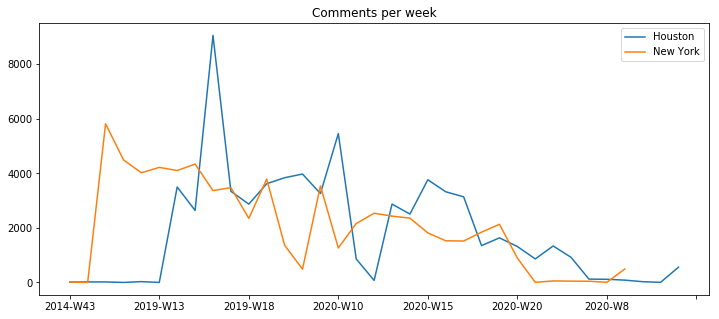

In [9]:
for city in cities:
    covid[covid["city"]==city]["week"] \
        .value_counts() \
        .sort_index() \
        .plot(
            title = "Comments per week",
            figsize = (12, 5),
            label = city,
            legend = "on"
        );

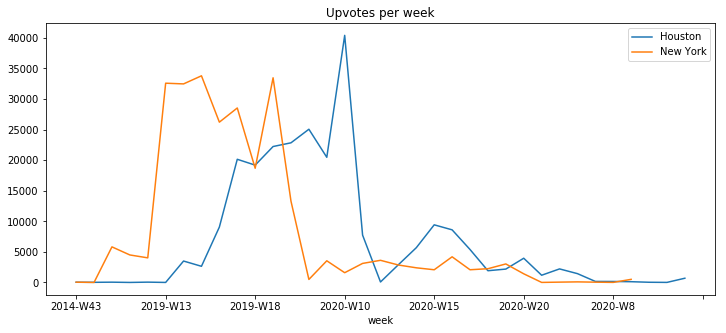

In [10]:
for city in cities:
    covid[covid["city"] == city] \
        .groupby("week") \
        .sum()["score"].plot(
            title = "Upvotes per week",
            figsize = (12, 5),
            label = city,
            legend = "on"
        );

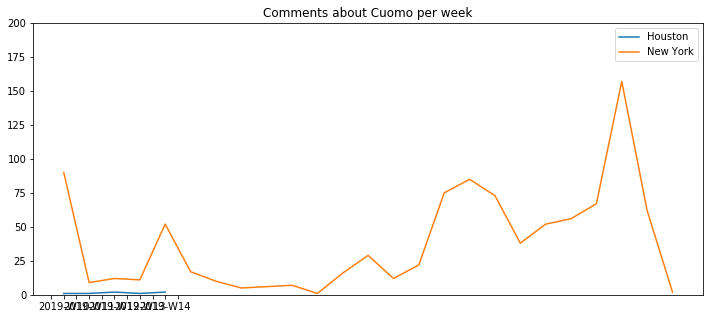

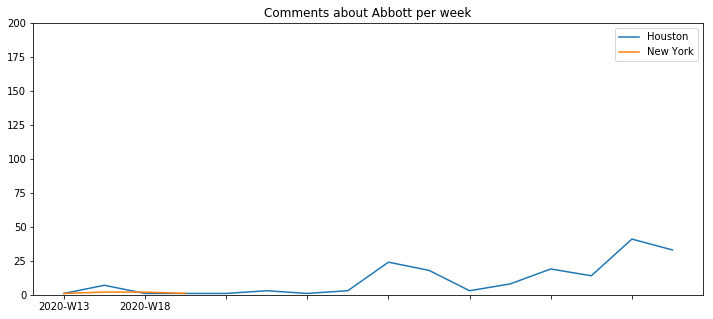

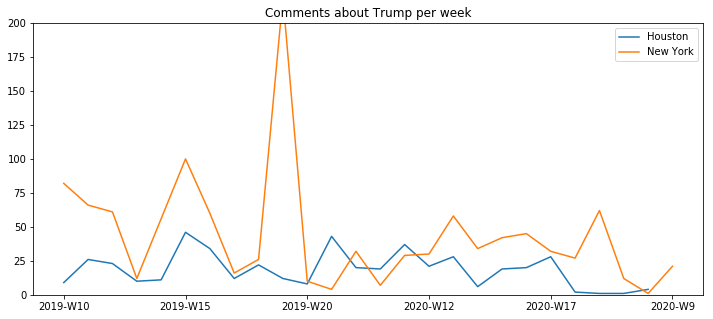

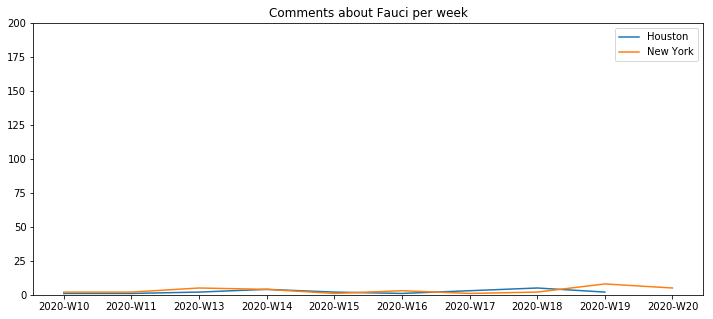

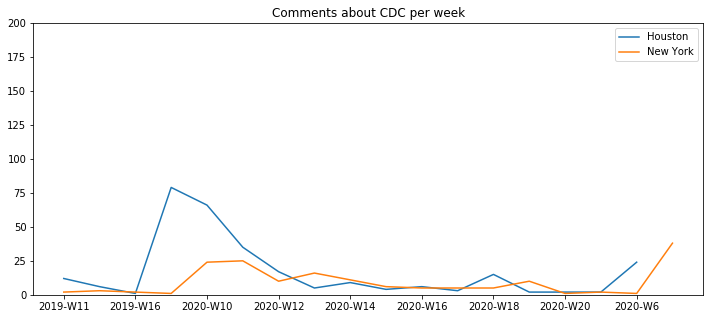

In [11]:
# Make sure we have sufficient data to graph on each keyword
for keyword in ["Cuomo", "Abbott", "Trump", "Fauci", "CDC"]:
    plt.figure()
    for city in cities:
        covid[(covid["city"]==city) & (covid["text"].str.contains(keyword, case=False))]["week"] \
            .value_counts() \
            .sort_index() \
            .plot(
                title = f"Comments about {keyword} per week",
                figsize = (12, 5),
                label = city,
                legend = "on",
                ylim = (0, 200)
            );

# Sentiment analysis

## Generate sentiment metrics

In [12]:
# Instantiate sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Compute sentiments
sentiments = pd.DataFrame([analyzer.polarity_scores(text) for text in covid["text"]])

# Append to original data frame
covid = pd.concat([covid, sentiments.set_index(covid.index)], axis=1)

In [13]:
# Define weighting scheme, with a "scaling back" factor to temper the range of the graphs
covid["score_weighted"] = covid["compound"] * covid["score"] * 0.75

In [110]:
# Define sentiment intensity
covid["intensity"] = np.abs(covid["score_weighted"])

## EDA on sentiment data

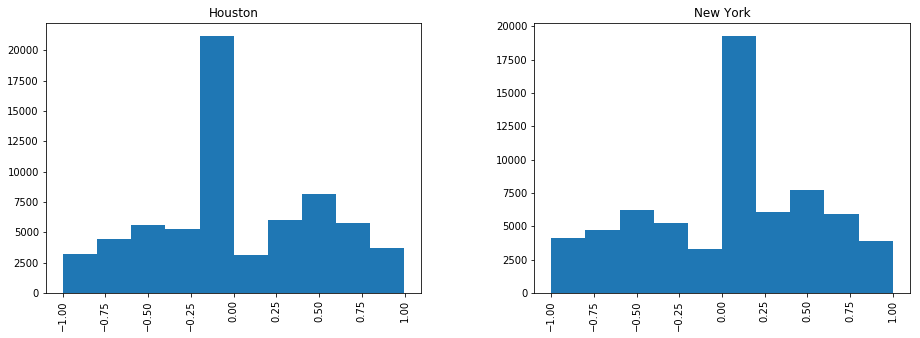

In [15]:
# Check distriution of sentiments by city;
covid.hist(column="compound", by="city", figsize=(15, 5));

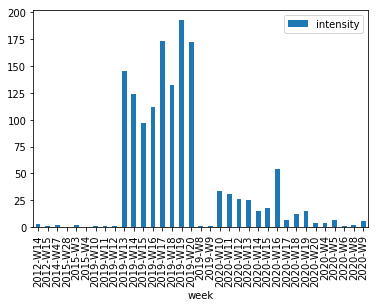

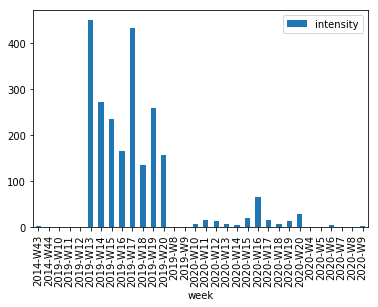

In [34]:
# Check which posts carry the greatest/least weighted sentiment
# (i.e., where are the peaks and valleys on the graphs coming from?)
for city in cities:
    covid[covid["city"] == city] \
        .groupby("week")[["link_id", "intensity"]].max() \
        .plot.bar();

# Graphs

In [116]:
def plt_setup(ax, title, year, xlabel="", ylabel=""):
    """Set up matplotlib graph with standard settings"""
    ax.set_title(title, fontsize=28)
    ax.set_xlabel(xlabel, fontsize=20)
    ax.set_ylabel(ylabel, fontsize=20)
    ax.tick_params(labelsize=16)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    ax.xaxis_date()
    ax.set_xlim((
            covid[covid["time"].dt.year == year]["time"].min() - pd.DateOffset(2),
            covid[covid["time"].dt.year == year]["time"].max() + pd.DateOffset(2)
        ))
    ax.set_xticks(
        list(filter(lambda x: x.day == 1,
               pd.date_range(
                covid[covid["time"].dt.year == year]["time"].min() - pd.DateOffset(2),
                covid[covid["time"].dt.year == year]["time"].max() + pd.DateOffset(2)
            ))))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b"))
    ax.set_ylim((0, 200))
    ax.set_yticks([-66.667, 66.667])
    ax.set_yticklabels(["☹", "☺"], fontsize=28)

    ax.axhline(0, color="gray")

def plt_city(ax, df, city, weight=False):
    """Plot a line graph of sentiment for a given city with given data df"""
    column = "intensity" if weight else "compound"
    
    # Draw line plot
    if df.shape[0] > 2:
        ax.plot(
            df.index,
            df[column] * 100,
            linewidth = 3,
            color = colors[city],
            label = ""
        );
        # Annotations
        ax.text(
            x = df.index[0],
            y = df[column][0] * 100 + 5,
            s = city,
            fontsize = 20,
            horizontalalignment = "center"
        )    

def plt_add_events(ax, events, period_begin, period_end):
    """Plot events, timeline-style, along the x-axis"""
    for city in cities:
        for event in events[city]:
            if pd.to_datetime(period_begin) <= pd.to_datetime(event[0]) <= pd.to_datetime(period_end):
                ax.text(
                    x = pd.to_datetime(event[0]),
                    y = event[2],
                    s = event[1],
                    fontsize = 12,
                    color = colors[city]
                )
                ax.vlines(
                    x = pd.to_datetime(event[0]),
                    ymin = event[2],
                    ymax = -100,
                    linestyle = ":"
                )

## Old comments

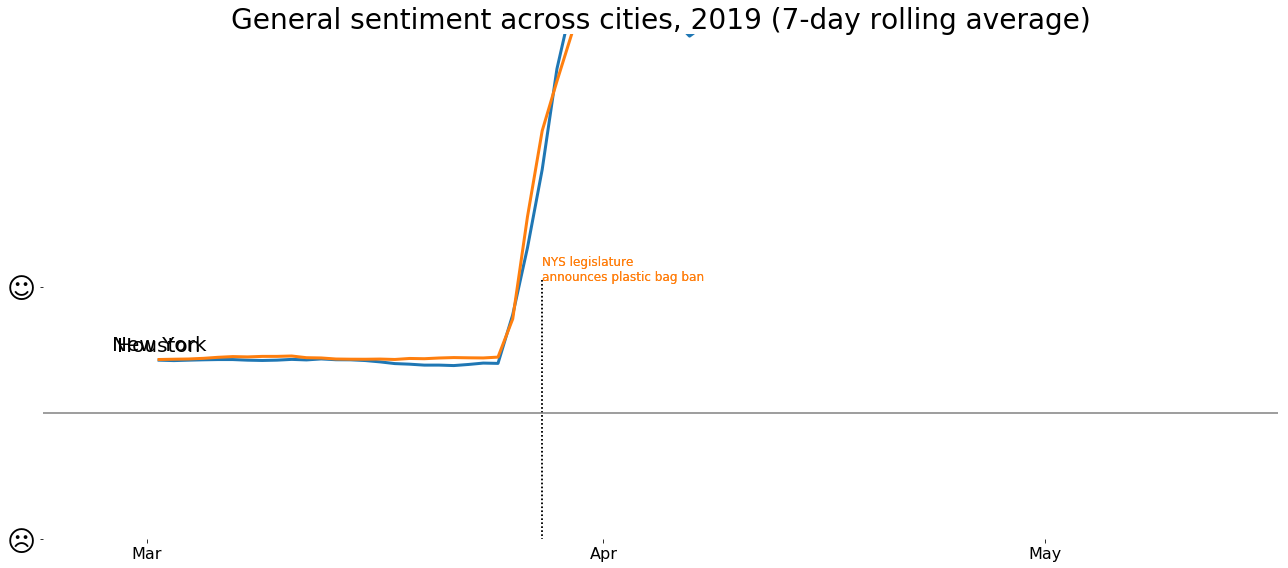

In [117]:
rolling = 7
year = 2019

# Configure plots
fig, ax = plt.subplots(figsize=(18, 8))
plt_setup(ax, f"General sentiment across cities, {year} ({rolling}-day rolling average)", year)

for city in cities:

    # Gather data
    subset = covid[
        (covid["time"].dt.year == year) &
        (covid["city"] == city) &
        (covid["score"] > 0)
    ]
    subset_mean = subset\
        .groupby(subset["time"].dt.date) \
        .mean() \
        .rolling(rolling) \
        .mean() \
        .dropna()
    
    # Line plots
    plt_city(ax, subset_mean, city, weight=True)
    
    # Events
    plt_add_events(ax, events, "2019-03-01", "2019-05-31")
    
    # Write out
    plt.tight_layout()
    plt.savefig(f"../graphs/Sentiment-Citywide-{year}-{rolling}day.svg", transparent=True)

## Citywide

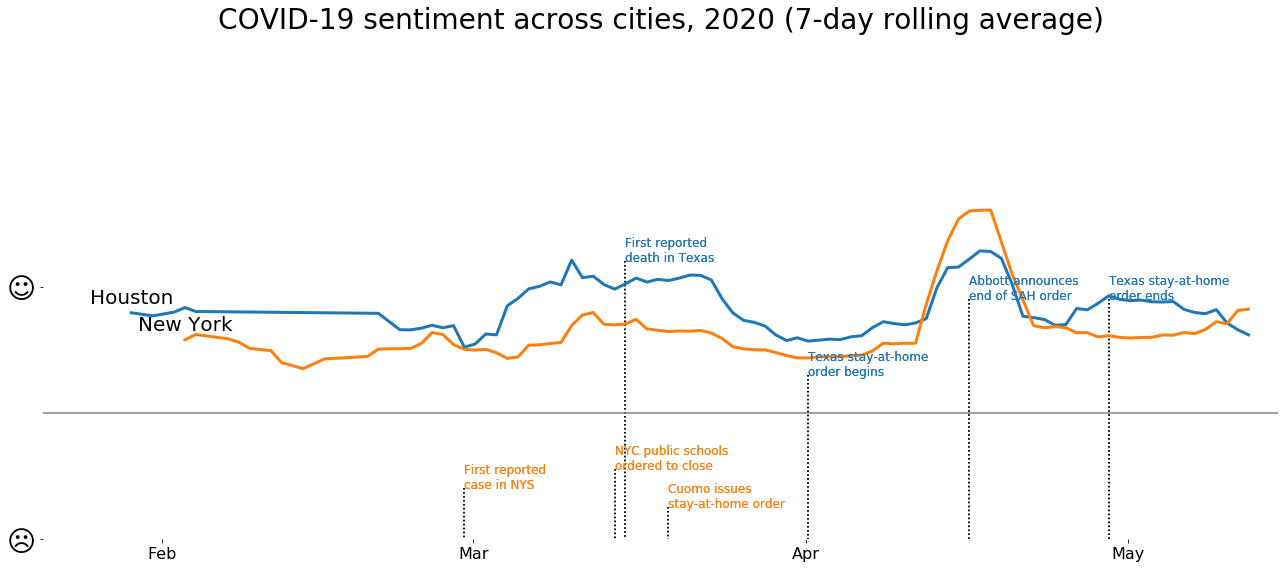

In [118]:
rolling = 7
year = 2020

# Configure plots
fig, ax = plt.subplots(figsize=(18, 8))
plt_setup(ax, f"COVID-19 sentiment across cities, {year} ({rolling}-day rolling average)", year)

for city in cities:

    # Gather data
    subset = covid[
        (covid["time"].dt.year == year) &
        (covid["city"] == city) &
        (covid["score"] > 0)
    ]
    subset_mean = subset\
        .groupby(subset["time"].dt.date) \
        .mean() \
        .rolling(rolling) \
        .mean() \
        .dropna()
    
    # Line plots
    plt_city(ax, subset_mean, city, weight=True)
    
    # Events
    plt_add_events(ax, events, "2020-02-01", "2020-05-31")
    
    # Write out
    plt.
    plt.tight_layout()
    plt.savefig(f"../graphs/Sentiment-Citywide-{year}-{rolling}day.svg", transparent=True)

## Governors

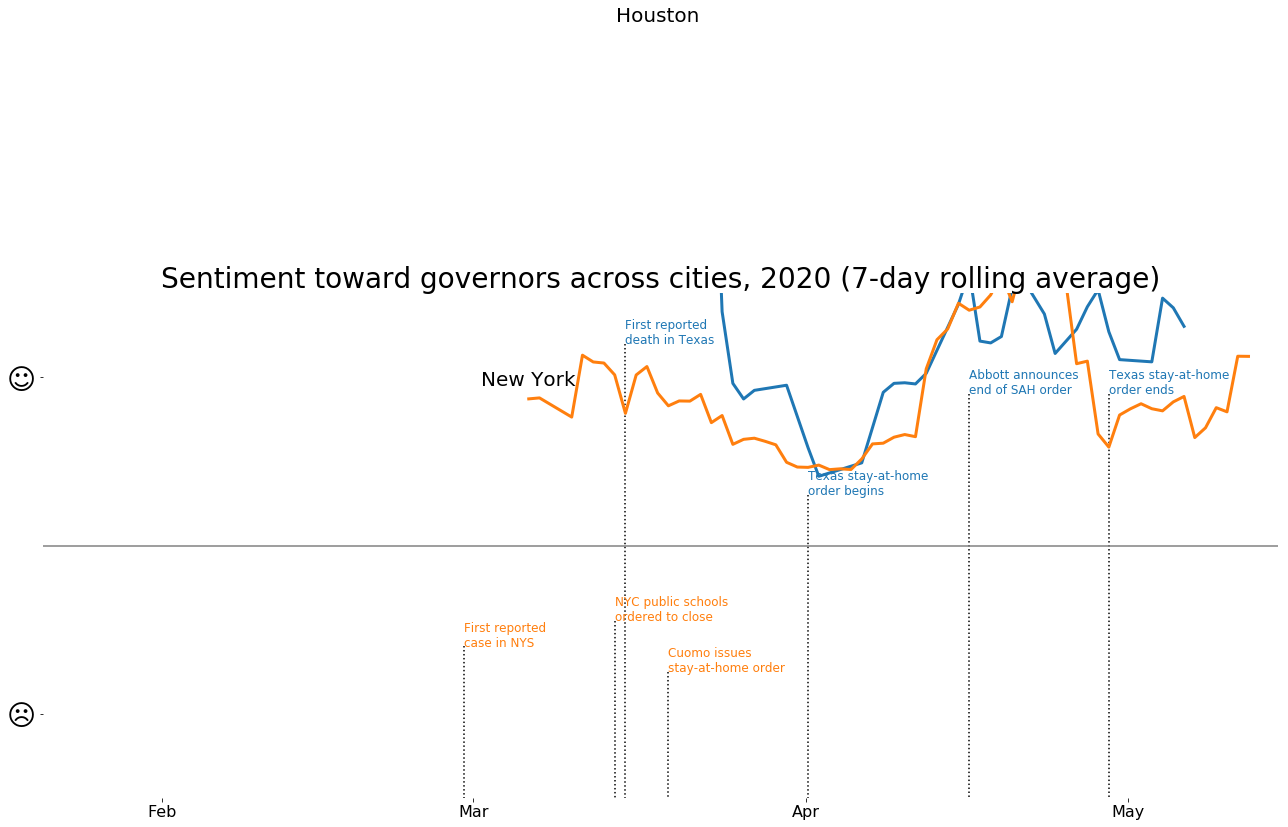

In [114]:
governors = {
    "New York": "Cuomo",
    "Houston": "Abbott"
}
rolling = 7
year = 2020

# Configure plots
fig, ax = plt.subplots(figsize=(18, 8))
plt_setup(ax, f"Sentiment toward governors across cities, {year} ({rolling}-day rolling average)", year)

for city in cities:
    # Gather data
    subset = covid[
        (covid["time"].dt.year == year) &
        (covid["city"] == city) &
        (covid["text"].str.contains(governors[city], case=False)) &
        (covid["score"] > 0)
    ]
    subset_mean = subset\
        .groupby(subset["time"].dt.date) \
        .mean() \
        .rolling(rolling) \
        .mean() \
        .dropna()
    
    # Line plots
    plt_city(ax, subset_mean, city, weight=True)

# Events
plt_add_events(ax, events, "2020-02-01", "2020-05-31")

# Write out
plt.tight_layout()
plt.savefig(f"../graphs/Sentiment-Governors-{rolling}day.svg", transparent=True)

## National figures

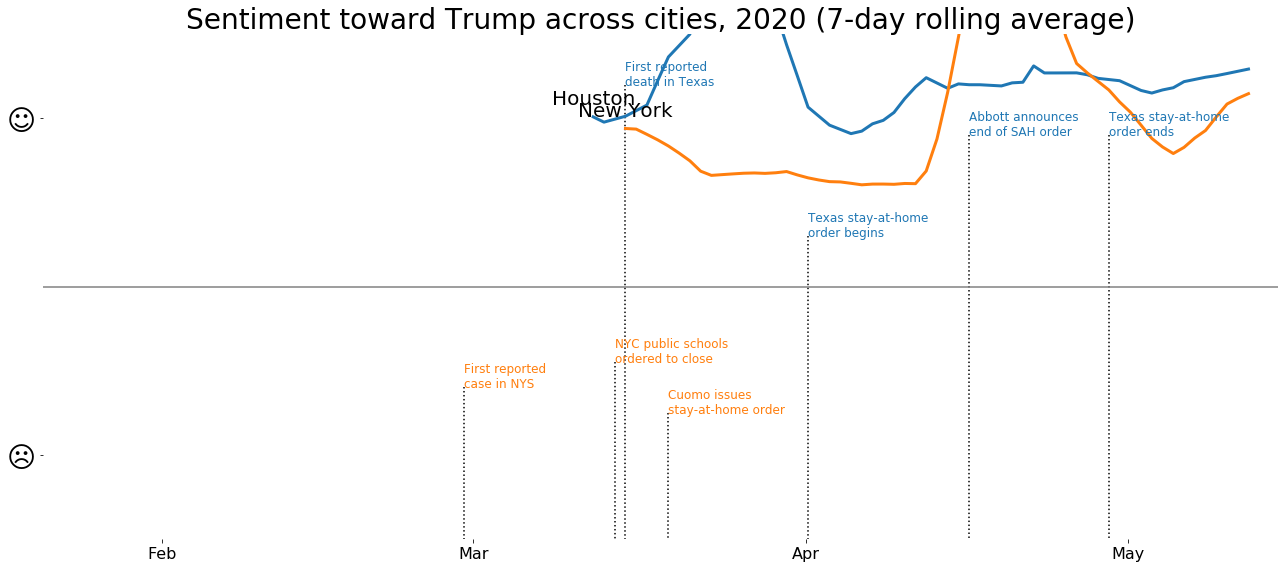

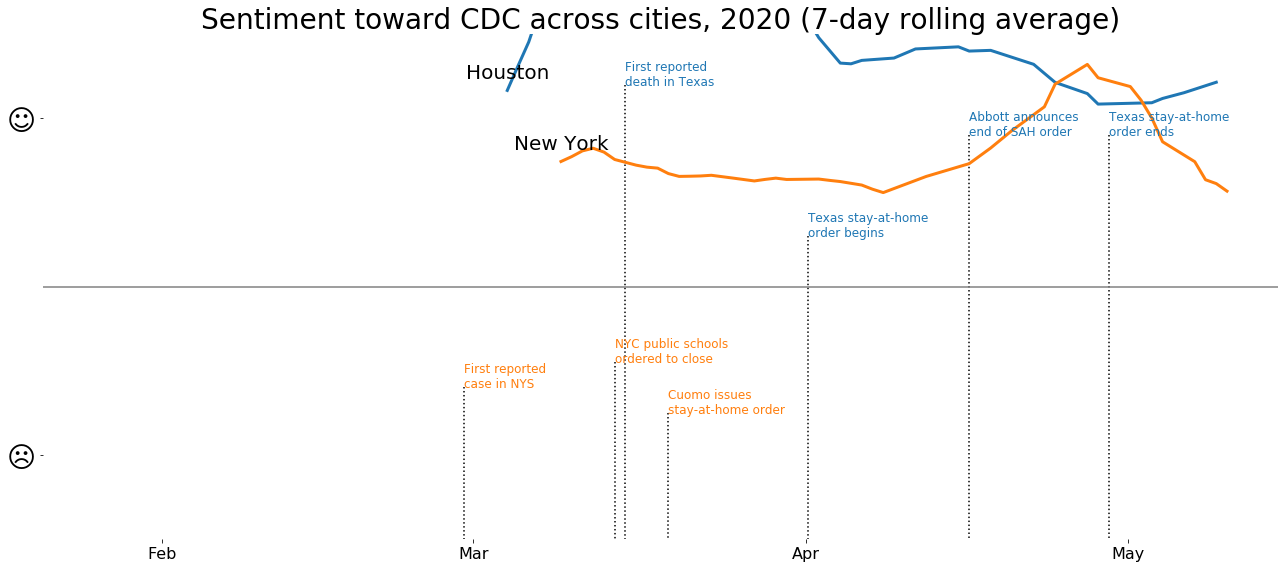

In [115]:
rolling = 7
year = 2020

for keyword in ["Trump", "CDC"]:

    # Configure plots
    fig, ax = plt.subplots(figsize=(18, 8))        
    plt_setup(ax, f"Sentiment toward {keyword} across cities, {year} ({rolling}-day rolling average)", year)

    for city in cities:
        # Gather data
        subset = covid[
            (covid["time"].dt.year == year) &
            (covid["city"] == city) &
            (covid["text"].str.contains(keyword, case=False)) &
            (covid["score"] > 0)
        ]
        subset_mean = subset\
            .groupby(subset["time"].dt.date) \
            .mean() \
            .rolling(rolling) \
            .mean() \
            .dropna()

        # Line plots
        plt_city(ax, subset_mean.rolling(rolling).mean().dropna(), city, weight=True)

    # Events
    plt_add_events(ax, events, "2020-02-01", "2020-05-31")
    
    # Write out
    plt.tight_layout()
    plt.savefig(f"../graphs/Sentiment-{keyword}-{rolling}day.svg", transparent=True)

# References

Hutto, C. J. and Gilbert, E. E. Aug. 2014. [VADER: A parsimonious rule-based model for sentiment analysis of social media text.](http://www.aaai.org/ocs/index.php/ICWSM/ICWSM14/paper/view/8109) In Adar, E., Resnick, P., Choudhury, M. D., Hogan, B., and Oh, A. H., eds., *Proceedings of the Eighth International Conference on Weblogs and Social Media*, pp. 216–225. Palo Alto, CA: AAAI Press